In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd
from numpy import load

import matplotlib.pyplot as plt
from matplotlib import cm 
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import time, cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB3

from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

import itertools

from sklearn import metrics

import seaborn as sns

In [ ]:
'''
#generation des données en 100*100

#data source
hemo = pd.read_csv('/content/drive/My Drive/Projet_AVC/hemorrhage_diagnosis.csv')

#regrouper toutes les images dans des vecteurs X_brain et y_brain, X_bone et y_bone
X_brain = []
X_mask = []

for index, row in hemo.iterrows():
    
    slice_num = str(row.SliceNumber)
    
    if row['PatientNumber'] < 100:
        pt_number = '0'+ str(row['PatientNumber'])
    else:
        pt_number = str(row['PatientNumber'])
    
    if (row['No_Hemorrhage'] == 0):
        file_mask = '/content/drive/My Drive/Projet_AVC/Patients_CT/'+ pt_number + '/brain/' + slice_num +'_HGE_Seg.jpg'
        img_mask = cv2.imread(file_mask, cv2.IMREAD_GRAYSCALE)
        img_mask_resized = cv2.resize(img_mask, (150,150), interpolation = cv2.INTER_AREA)
        X_mask.append(img_mask_resized)
    else:
        img_mask = np.zeros((150,150), np.uint8)
        X_mask.append(img_mask)
        
        
    file_brain = '/content/drive/My Drive/Projet_AVC/Patients_CT/'+ pt_number + '/brain/' + slice_num +'.jpg'
    file_bone = '/content/drive/My Drive/Projet_AVC/Patients_CT/'+ pt_number + '/bone/' + slice_num +'.jpg'
    img_brain = cv2.imread(file_brain)
    img_brain_resized = cv2.resize(img_brain, (150,150), interpolation = cv2.INTER_AREA)
    X_brain.append(img_brain_resized)
    
X_brain = np.array(X_brain)
X_mask = np.array(X_mask)

#Save in binary data
np.save('/content/drive/My Drive/Colab_outputs/X_brain_150.npy', X_brain)
np.save('/content/drive/My Drive/Colab_outputs/X_mask_150.npy', X_mask)

On va charger les données en 150x150 car la RAM a tendance à planter en 256x256

In [ ]:
#chargement de X_brain et y_brain
np.load.__defaults__=(None, True, True, 'ASCII')

X_brain= load('/content/drive/My Drive/Colab_outputs/X_brain_150.npy')
y_brain = load('/content/drive/My Drive/Colab_outputs/y_brain.npy')

# Shape de X_brain et y_brain
print('Shape of X:', X_brain.shape)
print('Shape of y:',y_brain.shape)

Shape of X: (2501, 150, 150, 3)
Shape of y: (2501,)


In [ ]:
### split des données ###

X_train, X_test, y_train, y_test = train_test_split(X_brain, y_brain, test_size=0.2)

# Shape de X_train et y_train
print('Shape of X:', X_train.shape)
print('Shape of y:',y_train.shape)

Shape of X: (2000, 150, 150, 3)
Shape of y: (2000,)


In [ ]:
# valeurs comprises entre 0 et 1 et transformation en vecteurs catégoriels binaires

X_train = X_train/255
X_test = X_test/255

In [ ]:
X_train[0,...].shape

(150, 150, 3)

Les CNN ont été construit pour traiter de la donnée de type image. Les couches de convolution sont aujourd'hui vues comme les meilleurs extracteurs de features pour des problèmes de classification liés à l'image. Pour la suite, nous utiliserons le modèle Lenet. Et si nécessaire, tenterons d'y apporter quelques optimisations.

In [ ]:
## Réseau de Neurones Convolutif LeNet5

inputs = Input(shape = X_train[0,...].shape)
layer1 = Conv2D(filters = 30, kernel_size = (5, 5), padding = 'valid', activation = 'relu')
layer2 = MaxPooling2D(pool_size=(2,2))
layer3 = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'valid', activation = 'relu')
layer4 = MaxPooling2D(pool_size=(2,2))
layer5 = Dropout(rate = 0.2)
layer6 = Flatten()
layer7 = Dense(units=128, activation = 'relu')
output_layer = Dense(units=1, activation = 'sigmoid')

x = layer1(inputs)
x = layer2(x)
x = layer3(x)
x = layer4(x)
x = layer5(x)
x = layer6(x)
x = layer7(x)
outputs = output_layer(x)

model = Model(inputs = inputs, outputs = outputs)

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

Afin d'éviter le surapprentissage nous mettons en place le earlyStopping qui consiste à interrompre le processus prématurément.
La description de chaque callback est donnée au dessus

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

EPOCHS = 25

# EarlyStopping qui suit la valeur val_loss, arrête l'entraînement s'il n'y a pas de changement vers val_loss après 3 époques et conserve les meilleurs poids une fois que l'entraînement s'arrête
early_stopping = EarlyStopping(monitor = 'val_loss',
                    min_delta = 0.01,
                    mode = 'min',
                    patience = 3,
                    verbose = 1,
                    restore_best_weights = True)

#ReduceLROnPlateau qui suit la métrique val_loss, divise le coefficient d'apprentissage par 2 si au bout de 3 epochs, val_loss n'a pas varié de 0.01. 
#On attribue une pause de 2 epochs entre 2 cycles
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                        min_delta = 0.01,
                        patience = 3,
                        factor = 0.5, 
                        cooldown = 2,
                        verbose = 1)

# save the best model
checkpoint_filepath = '/content/drive/My Drive/Colab_outputs/tmp/checkpoint'

model_checkpoint = ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_accuracy',
                        mode='max',
                        save_best_only=True)

training_history_lenet = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = 200, validation_split = 0.2, callbacks=[model_checkpoint, reduce_learning_rate, early_stopping])

# The model weights (that are considered the best) are loaded into the model
model.load_weights(checkpoint_filepath)

Epoch 1/25
8/8 [==============================] - 60s 7s/step - loss: 0.5149 - accuracy: 0.8431 - val_loss: 0.3207 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 2/25
8/8 [==============================] - 56s 7s/step - loss: 0.3177 - accuracy: 0.8712 - val_loss: 0.2965 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 3/25
8/8 [==============================] - 56s 7s/step - loss: 0.2835 - accuracy: 0.8712 - val_loss: 0.2677 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 4/25
8/8 [==============================] - 57s 7s/step - loss: 0.2633 - accuracy: 0.8712 - val_loss: 0.2485 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 5/25
8/8 [==============================] - 61s 8s/step - loss: 0.2388 - accuracy: 0.8712 - val_loss: 0.2319 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 6/25
8/8 [==============================] - 57s 7s/step - loss: 0.2138 - accuracy: 0.8725 - val_loss: 0.2210 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/25
8/8 [==============================] - 56s 7s/step - loss: 0.1936 - accuracy: 0.898

In [ ]:
train_acc = training_history_lenet.history['accuracy']
val_acc = training_history_lenet.history['val_accuracy']
train_loss = training_history_lenet.history['loss']
val_loss = training_history_lenet.history['val_loss']

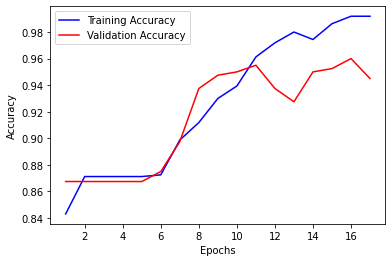

In [ ]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 18, 1),
         train_acc,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , 18, 1),
         val_acc, 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [ ]:
#prediction 
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

test_pred_class = []

for i in test_pred[:,0]:
    if i > 0.5:
        test_pred_class.append(1)
    else:
        test_pred_class.append(0)

63/63 [==============================] - 19s 296ms/step


In [ ]:
test_pred_array = np.array(test_pred_class)

In [ ]:
pd.crosstab(y_test, test_pred_array, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,430,12
1,14,45


In [ ]:
#classification
print(metrics.classification_report(y_test, test_pred_class))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       442
           1       0.79      0.76      0.78        59

    accuracy                           0.95       501
   macro avg       0.88      0.87      0.87       501
weighted avg       0.95      0.95      0.95       501



In [ ]:
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
print(classification_report_imbalanced(y_test,test_pred_class))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.97      0.76      0.97      0.86      0.76       442
          1       0.79      0.76      0.97      0.78      0.86      0.73        59

avg / total       0.95      0.95      0.79      0.95      0.86      0.75       501



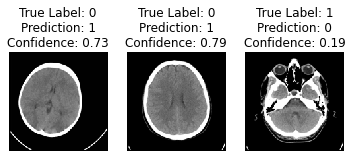

In [ ]:
error_indexes = []
for i in range(len(test_pred)):
    if(test_pred_class[i] != y_test[i]):
        error_indexes += [i]

j = 1
for i in np.random.choice(error_indexes, size = 3):
    img = X_test[i]
    
    plt.subplot(1, 3, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img,cmap = cm.binary, interpolation='None')
    plt.title('True Label: ' + str(y_test[i]) \
              + '\n' + 'Prediction: '+ str(test_pred_class[i]) \
              + '\n' + 'Confidence: '+ str(round(test_pred[i][0], 2)))

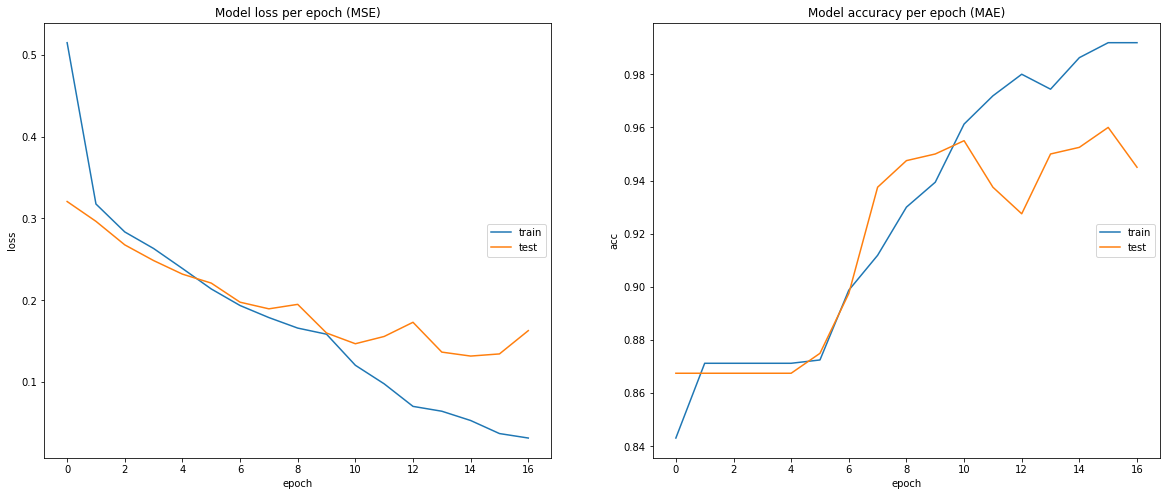

In [ ]:
plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch (MAE)')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.show()

L'accuracy et le loss du test suit la tendance de l'apprentissage, ce qui montre que nous ne sommes pas sur un cas de sur-apprentissage et que le modèle est plutôt bon poru ce qu'il doit faire: classifier

In [ ]:
import sklearn

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

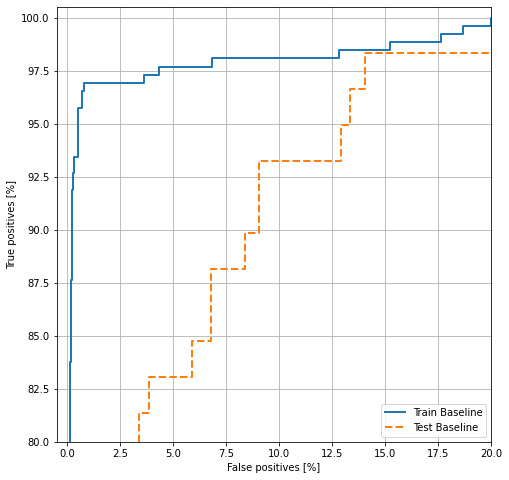

In [ ]:
plt.figure(figsize = (20, 8))

plot_roc("Train Baseline", y_train, train_pred)
plot_roc("Test Baseline", y_test, test_pred, linestyle='--')
plt.legend(loc='lower right');

Ce graphique (courbe ROC) est utile car il montre, d'un coup d'œil, la plage de performances que le modèle peut atteindre simplement en ajustant le seuil de sortie.

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

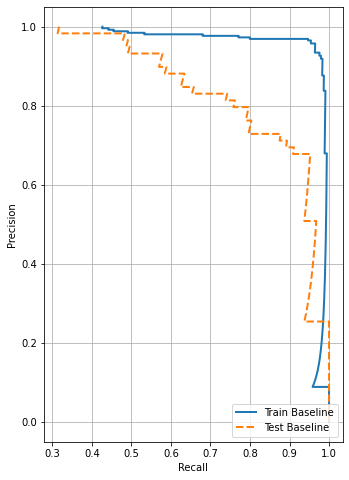

In [ ]:
plt.figure(figsize = (20, 8))

plot_prc("Train Baseline", y_train, train_pred)
plot_prc("Test Baseline", y_test, test_pred, linestyle='--')
plt.legend(loc='lower right');

In [ ]:
# optimisation par changement initila des poids de chaque classe

Bien que dans l'état actuel, le modèle donne des résultats très probants, nous allons vois si nous pouvons encore l'améliorer en modifiant les poids de chaque classe des labels, cad en donnant plus de poids à la présence d'une hémorragie qui est la classe minoritaire.

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
class_weights = {i:w for i,w in enumerate(class_weights)}

training_history_lenet_2 = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = 200, validation_split = 0.2, callbacks=[model_checkpoint, reduce_learning_rate, early_stopping], class_weight=class_weights)

Epoch 1/25
8/8 [==============================] - 65s 7s/step - loss: 0.0543 - accuracy: 0.9819 - val_loss: 0.1502 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 2/25
8/8 [==============================] - 56s 7s/step - loss: 0.0414 - accuracy: 0.9862 - val_loss: 0.1684 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 3/25
8/8 [==============================] - 64s 8s/step - loss: 0.0475 - accuracy: 0.9862 - val_loss: 0.1928 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/25
8/8 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9712
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 1.
8/8 [==============================] - 57s 7s/step - loss: 0.0619 - accuracy: 0.9712 - val_loss: 0.2564 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 4: early stopping


In [ ]:
#prediction 
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

test_pred_class = []

for i in test_pred[:,0]:
    if i > 0.5:
        test_pred_class.append(1)
    else:
        test_pred_class.append(0)

test_pred_array = np.array(test_pred_class)

pd.crosstab(y_test, test_pred_array, rownames=['Classe réelle'], colnames=['Classe prédite'])

63/63 [==============================] - 19s 292ms/step


Classe prédite,0,1
Classe réelle,,
0,421,21
1,8,51


In [ ]:
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
print(classification_report_imbalanced(y_test,test_pred_class))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.95      0.86      0.97      0.91      0.83       442
          1       0.71      0.86      0.95      0.78      0.91      0.82        59

avg / total       0.95      0.94      0.87      0.94      0.91      0.83       501



Cela a apporté une amélioration notable, mais perte de précision et de f1-score pour la classe minoritaire.